# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [59]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [60]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [61]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = good_arms + bad_arms
shuffle(arms)
arms = {arm.arm_id: arm for arm in arms}
arm_ids = list(arms.keys())

In [62]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 6.053505963875906


In [63]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [64]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najelpsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalezc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [65]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [66]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 604.0000000000001
random: 277.9


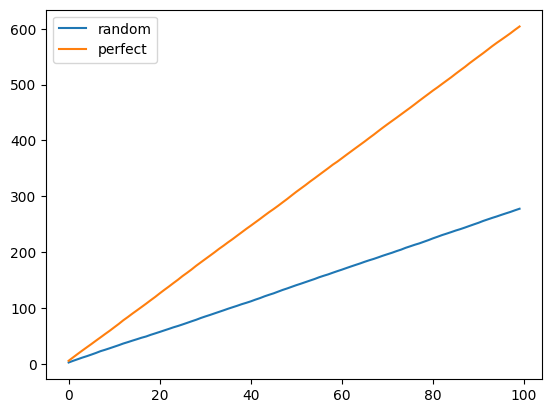

In [67]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.92
random: 2.76


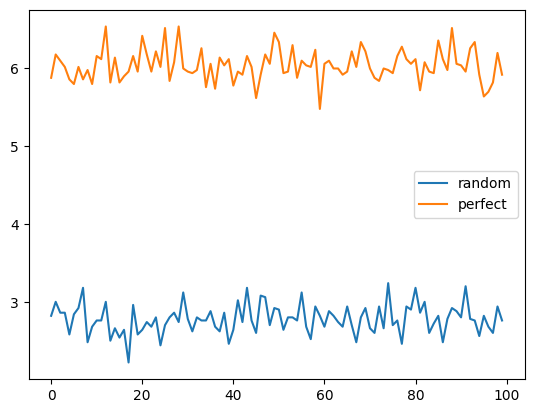

In [68]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [69]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        sorted_arm_ids = [arm_id for arm_id, _ in sorted(self.ctr.items(), key=lambda x: x[1], reverse=True)]
        random_arm_ids = sorted_arm_ids.copy()
        shuffle(random_arm_ids)
        
        result = []
        while len(result) != size:
            for sorted_arm_id, random_arm_id in zip(sorted_arm_ids, random_arm_ids):
                if len(result) == size:
                    break
                    
                if random() < self.epsilon:
                    potential_arm_id = random_arm_id
                else:
                    potential_arm_id = sorted_arm_id
                    
                if potential_arm_id not in result:
                    result.append(potential_arm_id)
                    
        for arm_id in result:
            self.impressions[arm_id] += 1
                    
        return result
        
    def feedback(self, arm_id, payout):
        self.clicks[arm_id] += payout
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]
        

In [79]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.impressions = {arm_id: 0 for arm_id in arm_ids}
        self.clicks = {arm_id: 0 for arm_id in arm_ids}
        self.ctr = {arm_id: 0.0 for arm_id in arm_ids}
        self.total_impressions = 0
    
    def recommend(self, size):
        result = [
            (arm_id, self.ctr[arm_id] + self.optimism_weight * self._optimism(arm_id))
            for arm_id in self.arm_ids
        ]
        result.sort(key=lambda x: x[1], reverse=True)
        result = [arm_id for arm_id, _ in result[:size]]
        
        for arm_id in result:
            self.impressions[arm_id] += 1
            
        self.total_impressions += size
            
        return result
    
    def feedback(self, arm_id, payout):
        self.clicks[arm_id] += payout
        self.ctr[arm_id] = self.clicks[arm_id] / self.impressions[arm_id]

    def _optimism(self, arm):
        try:
            return sqrt(
                (2 * log(self.total_impressions)) / self.impressions[arm]
            )
        except (ZeroDivisionError, ValueError):
            return 0
        

In [80]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    
    def recommend(self, size):
        result = [
            (arm_id, betavariate(self.reward_multiplier * self.a[arm_id], self.regret_multiplier * self.b[arm_id]))
            for arm_id in self.arm_ids
        ]
        result.sort(key=lambda x: x[1], reverse=True)
        result = [arm_id for arm_id, _ in result[:size]]
        
        for arm_id in result:
            self.b[arm_id] += self.regret_multiplier
        
        return result
    
    def feedback(self, arm_id, payout):
        self.a[arm_id] += payout * self.reward_multiplier
        self.b[arm_id] -= payout * self.regret_multiplier

## Część 3. - zgrubne porównanie bandytów

In [81]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [82]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_10_1: 6.34
ts_5_10: 6.12
ts_1_50: 6.02
ts_5_20: 6.0
ts_20_20: 6.0
perfect: 5.92
egreedy_0.1: 5.64
ts_1_5: 5.64
ts_1_20: 5.6
ts_50_10: 5.6
ts_10_50: 5.58
ts_20_1: 5.58
ts_50_1: 5.58
ts_5_1: 5.56
ts_5_50: 5.56
ts_10_5: 5.52
egreedy_0.05: 5.48
ts_50_5: 5.46
ts_1_1: 5.42
ts_1_10: 5.4
ts_50_20: 5.06
ts_50_50: 5.0
egreedy_0.25: 4.94
ts_10_10: 4.92
ts_5_5: 4.9
egreedy_0.01: 4.78
ts_20_50: 4.62
ts_20_5: 4.54
ts_10_20: 4.52
ts_20_10: 4.38
ucb_0.1: 3.5
ucb_10: 3.4
ucb_0.01: 3.38
ucb_1: 3.34
random: 2.7


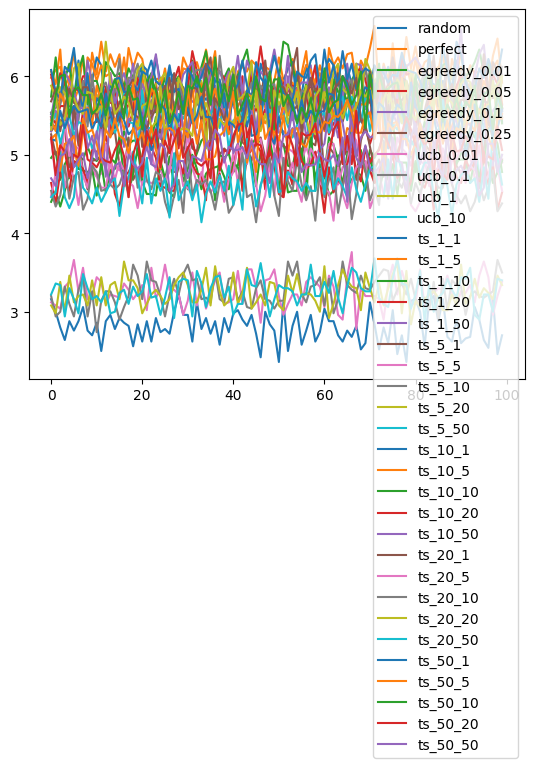

In [83]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 607.1799999999998
ts_10_1: 596.0600000000001
ts_1_50: 593.0600000000001
ts_1_10: 591.6999999999997
ts_1_5: 589.9000000000002
ts_1_1: 584.8399999999998
ts_1_20: 582.9200000000001
ts_5_20: 579.82
ts_5_10: 577.8399999999999
ts_50_10: 572.02
ts_5_1: 571.3399999999999
ts_20_1: 568.38
ts_20_20: 557.1800000000001
egreedy_0.05: 556.5599999999997
egreedy_0.1: 554.7
ts_10_5: 551.78
ts_50_1: 548.1800000000001
ts_5_50: 542.68
ts_10_50: 535.5799999999999
ts_50_5: 527.0599999999997
egreedy_0.25: 508.78000000000003
ts_50_20: 507.74000000000007
egreedy_0.01: 501.82
ts_50_50: 493.5799999999997
ts_5_5: 492.69999999999993
ts_10_20: 478.7399999999999
ts_10_10: 474.88000000000005
ts_20_5: 470.2799999999997
ts_20_50: 464.51999999999987
ts_20_10: 459.53999999999996
ucb_0.01: 326.53999999999996
ucb_0.1: 325.93999999999994
ucb_10: 325.58000000000004
ucb_1: 324.66000000000014
random: 280.96000000000004


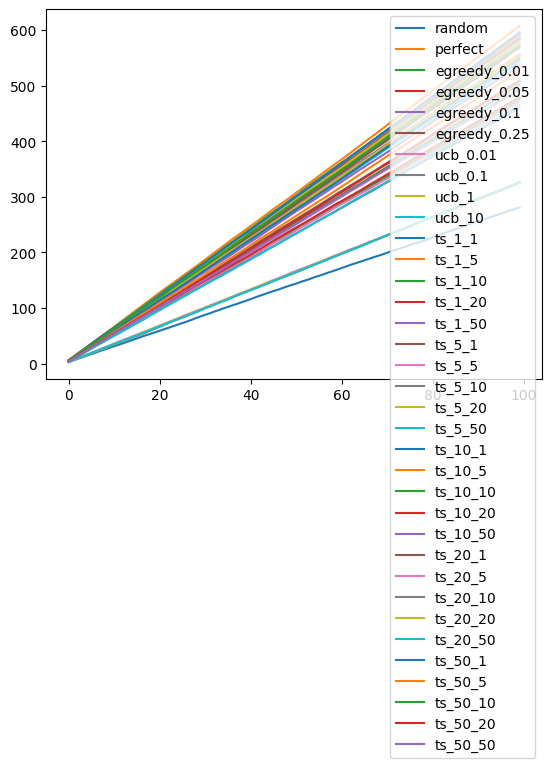

In [84]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [85]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [86]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    return relevant(recommendation[:k]) / k

def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    return relevant(recommendation[:k]) / all_relevant

In [87]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [88]:
class TestEntry:
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    return tabulate(data, headers, tablefmt='github')

In [90]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
tesing_bandits = [bandits[0], bandits[1], bandits[4], bandits[7], bandits[14]]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - genetujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
for bandit in bandits:
    for k in k_vals:
        precision_sum = 0
        recall_sum = 0
        for _ in range(samples):
            recommendation_ids = bandit.recommend(recommendation_size)
            recommendation = [arms[arm_id] for arm_id in recommendation_ids]
            precision_sum += precision_at_k(recommendation, k)
            recall_sum += recall_at_k(recommendation, k, all_relevant)
        results.append(TestEntry(bandit.bandit_id, k, precision_sum / samples, recall_sum / samples))
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci
print(print_test_results(results))

| bandit       |   k |   precision@k |   recall@k |
|--------------|-----|---------------|------------|
| egreedy_0.01 |   3 |      1        |       0.3  |
| egreedy_0.01 |   5 |      1        |       0.5  |
| egreedy_0.01 |  10 |      0.8      |       0.8  |
| egreedy_0.05 |   3 |      0.966667 |       0.29 |
| egreedy_0.05 |   5 |      1        |       0.5  |
| egreedy_0.05 |  10 |      0.93     |       0.93 |
| egreedy_0.1  |   3 |      0.833333 |       0.25 |
| egreedy_0.1  |   5 |      0.92     |       0.46 |
| egreedy_0.1  |  10 |      0.93     |       0.93 |
| egreedy_0.25 |   3 |      0.833333 |       0.25 |
| egreedy_0.25 |   5 |      0.7      |       0.35 |
| egreedy_0.25 |  10 |      0.71     |       0.71 |
| perfect      |   3 |      1        |       0.3  |
| perfect      |   5 |      1        |       0.5  |
| perfect      |  10 |      1        |       1    |
| random       |   3 |      0.233333 |       0.07 |
| random       |   5 |      0.1      |       0.05 |
| random    